In [1]:
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

# The tensor is created
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [3]:
sess = tf.Session()

# Var initializing
sess.run(x.initializer)
sess.run(y.initializer)

# Run
result = sess.run(f)
result

42

In [4]:
# Because I'm a good boy
sess.close()

In [5]:
# On a more pythonic way
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

result

42

In [6]:
# This does not load immediatly, just loads the graph
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()  # actually initializes all the variables
    result = f.eval()

result

42

In [7]:
# Created vars are automatically added to the default graph
x1 = tf.Variable(1)

x1.graph is tf.get_default_graph()

True

In [8]:
# We can add vars to the non-default graph with with
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [9]:
x2.graph is tf.get_default_graph()

False

In [10]:
# When running the same command multiple times for experimenting it is convenient to do
tf.reset_default_graph()

In [11]:
# A few things to not here:
# - tensorflow does auto scheduling
# - values are lost between compulations, meaning that
#   below w, x are calculated twice, once to find
#   y, then to find z
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [12]:
# This efficiently calculates y and z
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression with tensorflow

In [13]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape

# Adds a 1 before each row, representing the bias for linear reg
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)

# This is the formula for the normal equation that solves the linear regres
# It is its closed form
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
    
# theta for each var
theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952334e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0338000e-06],
       [-3.7813708e-03],
       [-4.2348403e-01],
       [-4.3721911e-01]], dtype=float32)

# Using autodiff

To find gradients automatically

In [14]:
# Never forget gradient descent requires scaled data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)

# Addind a scalar 1, which will have associated a theta, and which will represent the bias
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [15]:
# Using autodiff that provides gradient descent for free
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

# Starting the thetas with random values ranging -1 1
# Note that we started the bias as 1, and now we associate a theta to them as well
# We will have len(thetas) = len(vars) + 1 (1 theta per var, 1 theta for bias)
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [16]:
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)

        best_theta = theta.eval()

print("Best theta:")
print(best_theta)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


In [17]:
# Event easier with tensorflow grad descent optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)  # Another option
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)

        best_theta = theta.eval()

print("Best theta:")
best_theta

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:


array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

### Feeding Data to the Training Algorithm

In [18]:
# Placeholders
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    # Dict entry same name as var: A
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

B_val_1

array([[6., 7., 8.]], dtype=float32)

In [19]:
B_val_2

array([[ 9., 10., 11.],
       [12., 13., 14.]], dtype=float32)

### Mini-batch gradient descent

Each epoch computer the gradient from n batches

In [20]:
reset_graph()

n_epochs = 10
learning_rate = 0.01

# X and y as placeholders
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [21]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

batch_size = 10
n_batches = int(np.ceil(m / batch_size))

In [22]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

best_theta

array([[-1.5969890e+12],
       [-7.9015722e+12],
       [-2.5303769e+12],
       [ 1.5364800e+13],
       [-1.1422111e+13],
       [ 3.5357401e+12],
       [-3.5691104e+14],
       [-4.1215648e+12],
       [ 6.8208390e+12]], dtype=float32)

# Visualizing the Graph and Training Curves Using TensorBoard

In [23]:
reset_graph()

from datetime import datetime

# If file exists it will append to old logs and mess visualization
# so we make sure it does not happen with timestamps
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [24]:
# Nothing new...
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

# We could have done this which would have grouped mse and error under loss on graph visualization
#with tf.name_scope("loss") as scope:
#    error = y_pred - y
#    mse = tf.reduce_mean(tf.square(error), name="mse")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [25]:
# This will add a special node on the graph to track the mse
mse_summary = tf.summary.scalar('MSE', mse)

# This will log to a file
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [26]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.close()
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

On terminal:
```
$ ls -l tf_logs/
$ tensorboard --logdir tf_logs/
```

# Logistic Regression with Mini-Batch Gradient Descent

In [27]:
# Let's try the moon dataset
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=23)

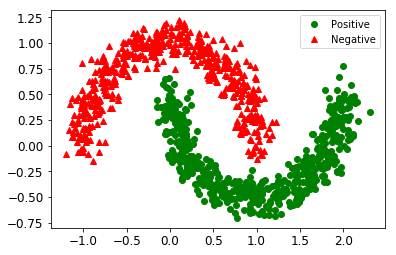

In [28]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [29]:
# For linear regression we need to add a vector of 1's for the bias
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [30]:
# Looks good
X_moons_with_bias[:5]

array([[ 1.        , -0.01094335,  0.31685554],
       [ 1.        ,  1.40619204, -0.2157393 ],
       [ 1.        ,  0.20714165,  0.92290529],
       [ 1.        ,  0.02247533,  0.41536302],
       [ 1.        ,  2.13828427,  0.41543376]])

In [31]:
# Input required to be vector of vectors
y_moons_column_vector = y_moons.reshape(-1, 1)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons_with_bias,
                                                    y_moons_column_vector,
                                                    test_size=0.2,
                                                    random_state=23,
                                                    shuffle=True)

In [33]:
# Very basic batch extractor will do the trick
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [34]:
reset_graph()

# Moons dataset has two features, both sides of a coordinate
n_inputs = 2

In [35]:
# Let's go
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

# Thetas vector randomized between [-1,1] (remember one theta is for the bias)
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")

# We're doing logistic so let's use tf sigmoid
y_proba = tf.sigmoid(logits)

# Log loss is good for log regression
loss = tf.losses.log_loss(y, y_proba)

learning_rate = 0.01
# Create an optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# Tell him to optimize cost function
training_op = optimizer.minimize(loss)

In [36]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 50
# m = 1000 (number datapoints)
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    # Irrelevant for, but it helps thinking in terms of epochs
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.81989014
Epoch: 100 	Loss: 0.35412085
Epoch: 200 	Loss: 0.32475048
Epoch: 300 	Loss: 0.30859002
Epoch: 400 	Loss: 0.3003244
Epoch: 500 	Loss: 0.29338893
Epoch: 600 	Loss: 0.29117763
Epoch: 700 	Loss: 0.28894493
Epoch: 800 	Loss: 0.287312
Epoch: 900 	Loss: 0.2858107


In [37]:
# Model outputs probabilities
y_proba_val[:5]

array([[0.97719234],
       [0.01236266],
       [0.08630466],
       [0.9872091 ],
       [0.9709971 ]], dtype=float32)

In [38]:
# Setting predictions at 50%
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [False],
       [False],
       [ True],
       [ True]])

In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.883495145631068

In [40]:
recall_score(y_test, y_pred)

0.8198198198198198

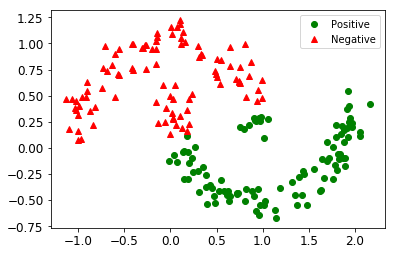

In [41]:
# Let's see what it looks like
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Ok job. Notice that linear regression has a linear decision boundary, and that's probably what is happening here. Let's improve this.

### Improving

In [52]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
X_train_poli = poly.fit_transform(X_train)
X_test_poli = poly.transform(X_test)

#X_train_poli = np.c_[X_train,
#                         np.square(X_train[:, 1]),
#                         np.square(X_train[:, 2]),
#                         X_train[:, 1] ** 3,
#                         X_train[:, 2] ** 3]
#X_test_poli = np.c_[X_test,
#                        np.square(X_test[:, 1]),
#                        np.square(X_test[:, 2]),
#                        X_test[:, 1] ** 3,
#                        X_test[:, 2] ** 3]

In [53]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [54]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [55]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [62]:
reset_graph()

n_inputs = X_test_poli.shape[1]

logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [63]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "./tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_poli, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_poli, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_poli, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.5363758
Epoch: 500 	Loss: 0.12188837
Epoch: 1000 	Loss: 0.08511942
Epoch: 1500 	Loss: 0.066926904
Epoch: 2000 	Loss: 0.057151124
Epoch: 2500 	Loss: 0.050127324
Epoch: 3000 	Loss: 0.045210533
Epoch: 3500 	Loss: 0.04109936
Epoch: 4000 	Loss: 0.03762536
Epoch: 4500 	Loss: 0.03577261
Epoch: 5000 	Loss: 0.03363408
Epoch: 5500 	Loss: 0.031821374
Epoch: 6000 	Loss: 0.030251928
Epoch: 6500 	Loss: 0.028873123
Epoch: 7000 	Loss: 0.027685432
Epoch: 7500 	Loss: 0.026569914
Epoch: 8000 	Loss: 0.025936652
Epoch: 8500 	Loss: 0.024954231
Epoch: 9000 	Loss: 0.02411037
Epoch: 9500 	Loss: 0.023414502
Epoch: 10000 	Loss: 0.022642862


In [58]:
y_pred = (y_proba_val >= 0.5)

In [59]:
precision_score(y_test, y_pred)

1.0

In [60]:
recall_score(y_test, y_pred)

0.990990990990991

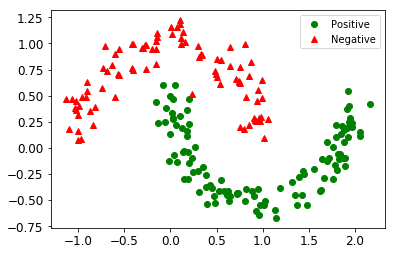

In [61]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()